 # CAM 

This notebook is based on code found at: 

https://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html.html


In [113]:
# !pip install torch torchvision matplotlib numpy scikit-image torchaudio

In [114]:
%matplotlib inline

from PIL import Image, ImageFilter, ImageOps
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import torch
import numpy as np
import skimage.transform

## Import
Import image that we want to classify. Based on code from SML course UU - lab exercise

RGB image of size (683, 683)


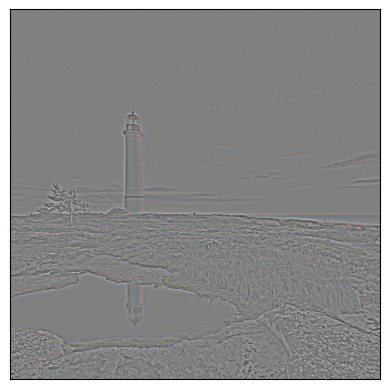

In [115]:
from urllib.request import urlopen
from urllib.error import URLError
import matplotlib.pyplot as plt

image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Felis_catus-cat_on_snow.jpg/640px-Felis_catus-cat_on_snow.jpg'

lighthouse_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse_original.jpg?raw=true'
lighthouse_90deg_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse_90deg.jpg?raw=true'
lighthouse_blur_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse_blur.jpg?raw=true'
lighthouse_highpass_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse_highpass.jpg?raw=true'
lighthouse_mix_channel_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse_mix_channel.jpg?raw=true'
lighthouse_noise_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse_noise.jpg?raw=true'
lighthouse_equalized_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/lighthouse%20equalized.jpg?raw=true'

lighthouse_url_list = [
    lighthouse_url,
    lighthouse_90deg_url,
    lighthouse_blur_url,
    lighthouse_highpass_url,
    lighthouse_mix_channel_url,
    lighthouse_noise_url,
    lighthouse_equalized_url   
]

description = ['Original', '90deg', 'Gaussian blur', 'Highpass filtered', 'Mixed color channels', 'Noise', 'Hist.equalized']

lighthouse_image_list = []
for i in range(len(lighthouse_url_list)):
    
    try:
        with Image.open(urlopen(lighthouse_url_list[i])) as im:
            # The following fixes some problems when loading images:
            # https://stackoverflow.com/a/64598016
            lighthouse_image_list.append(im.convert("RGB"))
    except (URLError, OSError):
        print("please provide a valid URL or local path")


 
print(f"{lighthouse_image_list[3].mode} image of size {lighthouse_image_list[3].size}")
plt.imshow(np.asarray(lighthouse_image_list[3]))
plt.xticks([])
plt.yticks([])
plt.show()

Store class names in a dictionary

In [116]:
# Define the URL of the raw text file on GitHub
class_name = {}

# Define the URL of the raw text file on GitHub
url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'

try:
    # Open the URL and read the contents of the file
    with urlopen(url) as response:
        text = response.read().decode('utf-8')
        text = text.replace('{', '')
        text = text.replace('}', '')

        for line in text.splitlines():
            key, value = line.split(':')
            key = int(key)
    
            if value.count(',') >= 2:
                value = value.replace(',', '\n', 1)
            # remove last , if present
            if value.endswith(','):
                value = value[:-1]

            class_name[key] = value.replace("'", "")

except URLError as e:
    print("please provide a valid URL or local path")

# set  beacon, lighthouse, beacon light, pharos to lighthouse for less printing
class_name[437] = 'lighthouse'

# print some random class names


Import the 3 images for attention maps

In [117]:
sandal_url = "https://raw.githubusercontent.com/Okrash0/Explainable-Artificial-Intelligence/main/fig/sandal.jpg"
toilet_url = "https://raw.githubusercontent.com/Okrash0/Explainable-Artificial-Intelligence/main/fig/toilet.jpg"

In [118]:
image_url_list = [sandal_url, toilet_url]
image_list = []

for i in range(len(image_url_list)):
    
    try:
        with Image.open(urlopen(image_url_list[i])) as im:
            # The following fixes some problems when loading images:
            # https://stackoverflow.com/a/64598016
            image_list.append(im.convert("RGB"))
    except (URLError, OSError):
        print("please provide a valid URL or local path")

image_name_list = ["toilet", "sandal", "lighthouse"]

image_list.append(lighthouse_image_list[0])

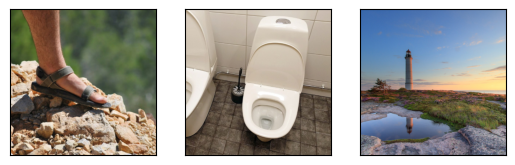

In [119]:
# show images in subplots 
fig, axs = plt.subplots(1, len(image_list))
for i in range(len(image_list)):
    axs[i].imshow(np.asarray(image_list[i]))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

In [120]:
def plot_images_1(image_list, mode=None):
    fig, axs = plt.subplots(1, len(image_list))
    for i in range(len(image_list)):
        axs[i].imshow(np.asarray(image_list[i]), cmap=mode)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    plt.show()

In [121]:
# import all filtering funcionts from filtering_functions.py
from filtering_functions import *

### Apply the filters
Just for testing right now 

<PIL.Image.Image image mode=RGB size=683x683 at 0x1BE8C10F350>


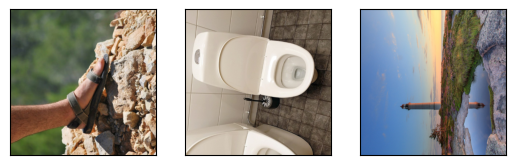

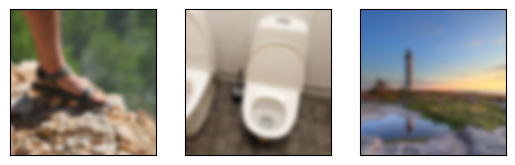

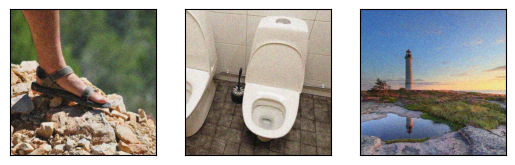

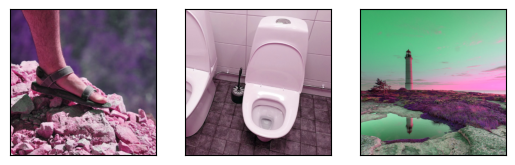

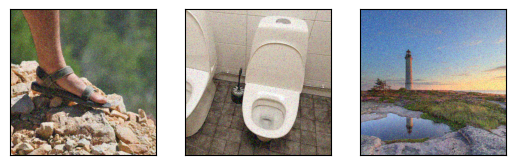

In [122]:
print(image_list[0])

rotated_list = []
for i in range(len(image_list)):
    rotated_list.append(rotate_filter(image_list[i]))

plot_images_1(rotated_list)

gause_list = []
for i in range(len(image_list)):
    gause_list.append(blur_filter(image_list[i], 10))

plot_images_1(gause_list)

noise_list = []
for i in range(len(image_list)):
    noise_list.append(gaussian_noise_filter(image_list[i]))

plot_images_1(noise_list)

mix_list = []
for i in range(len(image_list)):
    mix_list.append(mix_color_filter(image_list[i], 2))

plot_images_1(mix_list)

salt_list = []
for i in range(len(image_list)):
    salt_list.append(salt_and_pepper_filter(image_list[i]))

plot_images_1(salt_list)

## Preprocess 

In [123]:
# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [124]:
lighthouse_tensors = []
for i in range(len(lighthouse_image_list)):
    lighthouse_tensors.append(preprocess(lighthouse_image_list[i]))

In [125]:
image_tensors = []
for i in range(len(image_list)):
    image_tensors.append(preprocess(image_list[i]))

In [126]:
prediction_var_list = []
for i in range(len(lighthouse_image_list)):
    prediction_var_list.append(Variable((lighthouse_tensors[i].unsqueeze(0)), requires_grad=True))


In [127]:
prediction_var_list_image = []
for i in range(len(image_list)):
    prediction_var_list_image.append(Variable((image_tensors[i].unsqueeze(0)), requires_grad=True))

## Load model

In [128]:
model = models.resnet18(pretrained=True)

C:\Users\MSI Laptop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\MSI Laptop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [129]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [130]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [131]:
final_layer = model._modules.get('layer4')

In [132]:
activated_features = SaveFeatures(final_layer)

## Make prediction

In [133]:
pred_probabilities_list = []

for i in range(len(lighthouse_tensors)):
    prediction = model(prediction_var_list[i])
    pred_probabilities_list.append(F.softmax(prediction).data.squeeze())
    activated_features.remove()



C:\Users\MSI Laptop\AppData\Local\Temp\ipykernel_6828\2287866501.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities_list.append(F.softmax(prediction).data.squeeze())


In [134]:
for i in range(len(lighthouse_tensors)):
    topk(pred_probabilities_list[i],1)
    print(topk(pred_probabilities_list[i],1))

torch.return_types.topk(
values=tensor([0.9973]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.6106]),
indices=tensor([972]))
torch.return_types.topk(
values=tensor([0.7377]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.1081]),
indices=tensor([646]))
torch.return_types.topk(
values=tensor([0.9865]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.9774]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.9987]),
indices=tensor([437]))


 https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
 
437: 'beacon, lighthouse, beacon light, pharos',

In [135]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]


In [136]:
# Define a function for grad-CAM
def grad_cam(model, input, target_layer):
    # Define hooks for gradients and activations
    gradients = None
    activations = None

    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_input[0]

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    # Register hooks to the target layer
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    # Make prediction
    output = model(input)
    pred = output.max(1, keepdim=True)[1]
    pred = pred.cpu().numpy()[0, 0]
    # print prediction index if you want to check later which class is predicted for each image
    print(f"prediction: {class_name[pred]}")

    # Get gradients
    model.zero_grad()
    output[0, pred].backward()

    # Unregister hooks
    target_layer._forward_hooks.clear()
    target_layer._backward_hooks.clear()

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = activations.detach()

    # Weight the channels by corresponding gradients
    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu(), 0)
    heatmap /= torch.max(heatmap)

    # Draw the heatmap
    # plt.matshow(heatmap.squeeze())
    # plt.show()
    return heatmap, pred


In [137]:
def plot_images_overlay_gradcam(images, tensor, overlay_list, titles, save_plot=False):
    """plot images with titles and overlay
    Args:
        images: list of images
        tensor: list of images
        overlay_list: list of overlay images
        titles: list of tensors with class index
    
    """
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))

    for i in range(n):
        if n == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(display_transform(images[i]))
        ax.imshow(skimage.transform.resize(
            overlay_list[i][0].cpu().numpy(), tensor[i].shape[1:3]), alpha=0.5, cmap='jet')
        ax.set_title(titles[i])
        ax.axis('off')

    if save_plot:
        plt.savefig('plot.png', bbox_inches='tight')

    plt.show()

prediction: lighthouse
prediction:  cliff
 drop, drop-off
prediction: lighthouse
prediction:  maze
 labyrinth
prediction: lighthouse
prediction: lighthouse
prediction: lighthouse


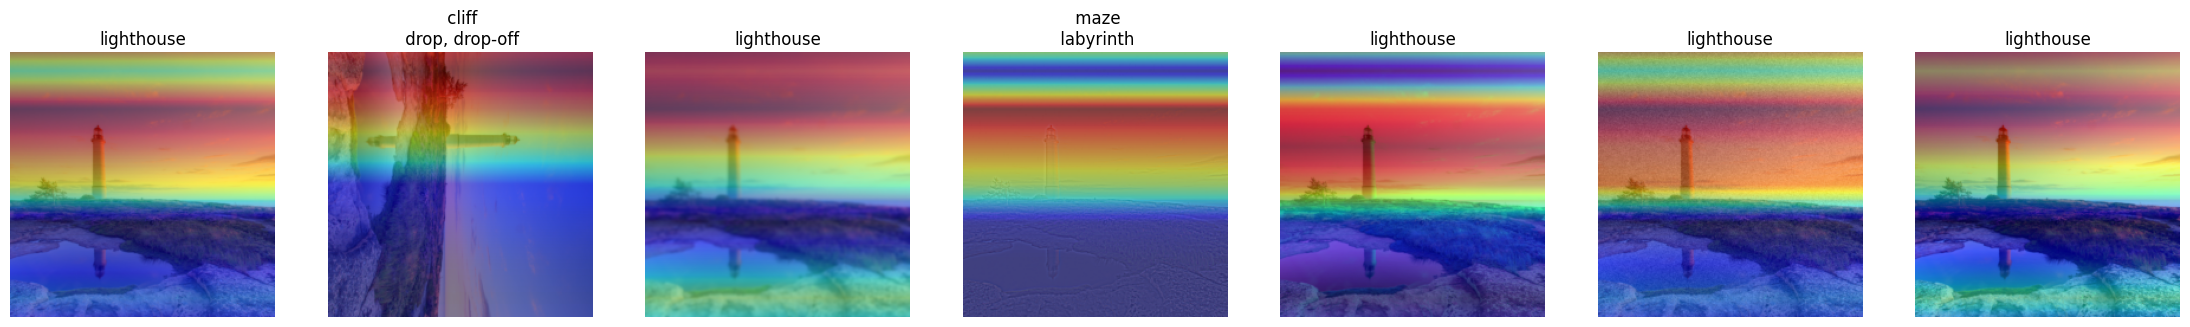

In [138]:
# invoke grad-CAM function and show results for each image in list and overlay on original image using imshow and skimage
img_list = []
title_list = []
heatmap_list = []
pred_list = []
for i in range(len(lighthouse_tensors)):
    heatmap, pred = grad_cam(model, prediction_var_list[i], final_layer)
    heatmap_list.append(heatmap)
    pred_list.append(pred)
    # get the class id from the top prediction of the model output and retrieve the corresponding class label from the dictionary
    img_list.append(lighthouse_image_list[i])
    # class_idx = topk(pred_probabilities_list[i],1)[1].int()
    title_list.append(class_name[pred_list[i]])


    # plt.imshow(display_transform(lighthouse_image_list[i]))
    # plt.imshow(skimage.transform.resize(heatmap.cpu().numpy(), lighthouse_tensors[i].shape[1:3]), alpha=0.5, cmap='jet')
    # plt.show()
plot_images_overlay_gradcam(img_list, lighthouse_tensors,heatmap_list,title_list)



In [139]:
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [140]:
weight_softmax_params

[Parameter containing:
 tensor([[-0.0185, -0.0705, -0.0518,  ..., -0.0390,  0.1735, -0.0410],
         [-0.0818, -0.0944,  0.0174,  ...,  0.2028, -0.0248,  0.0372],
         [-0.0332, -0.0566, -0.0242,  ..., -0.0344, -0.0227,  0.0197],
         ...,
         [-0.0103,  0.0033, -0.0359,  ..., -0.0279, -0.0115,  0.0128],
         [-0.0359, -0.0353, -0.0296,  ..., -0.0330, -0.0110, -0.0513],
         [ 0.0021, -0.0248, -0.0829,  ...,  0.0417, -0.0500,  0.0663]],
        requires_grad=True),
 Parameter containing:
 tensor([-2.6341e-03,  3.0005e-03,  6.5581e-04, -2.6909e-02,  6.3637e-03,
          1.3260e-02, -1.1178e-02,  2.0639e-02, -3.6373e-03, -1.2325e-02,
         -1.2629e-02, -7.2057e-03, -1.9321e-02, -2.4960e-02, -1.1885e-02,
         -8.3259e-03, -9.5745e-03, -1.6658e-02,  9.1804e-03, -1.5354e-02,
          7.1358e-03,  3.0737e-02,  1.3239e-02, -7.7528e-03,  4.7448e-03,
          1.1175e-02,  1.5949e-02, -1.6712e-02, -1.0130e-03, -3.7167e-03,
          6.5269e-03, -1.2041e-02,  9.04

In [141]:
overlay_list = []
class_list = []
for i in range(len(lighthouse_tensors)):
    class_idx = topk(pred_probabilities_list[i],1)[1].int()
    overlay_list.append(getCAM(activated_features.features, weight_softmax, class_idx))
    class_list.append(class_idx)
    print(topk(pred_probabilities_list[i],1))
    activated_features.remove()

torch.return_types.topk(
values=tensor([0.9973]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.6106]),
indices=tensor([972]))
torch.return_types.topk(
values=tensor([0.7377]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.1081]),
indices=tensor([646]))
torch.return_types.topk(
values=tensor([0.9865]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.9774]),
indices=tensor([437]))
torch.return_types.topk(
values=tensor([0.9987]),
indices=tensor([437]))


In [142]:
print(overlay_list)

[[array([[0.02907798, 0.05896041, 0.04734023, 0.03823022, 0.        ,
        0.00429485, 0.01391346],
       [0.16934359, 0.36284867, 0.41363007, 0.30448928, 0.09769841,
        0.01127305, 0.02393683],
       [0.37485084, 0.7500423 , 0.8488998 , 0.6569178 , 0.25483876,
        0.08750753, 0.08059465],
       [0.39476672, 0.8391885 , 1.        , 0.8099438 , 0.3663548 ,
        0.18527457, 0.12836346],
       [0.25931665, 0.63957083, 0.72517335, 0.61179566, 0.25731453,
        0.151675  , 0.09559552],
       [0.15000854, 0.2724889 , 0.2755416 , 0.25255603, 0.15919742,
        0.14231753, 0.09611443],
       [0.06093922, 0.06795017, 0.03738395, 0.04684478, 0.03607038,
        0.04159545, 0.02435018]], dtype=float32)], [array([[0.15420803, 0.05802032, 0.0880039 , 0.05402717, 0.10121741,
        0.15228438, 0.16071174],
       [0.19798082, 0.15973392, 0.11052229, 0.        , 0.08611904,
        0.17439418, 0.20812815],
       [0.34333318, 0.57013214, 0.3393801 , 0.3915239 , 0.332837  ,
  

## Plot heatmap of predicted class

Ploting functions

In [143]:
def plot_heatmap(overlay_images, titles, save_plot=False):
    """plot heatmap of images with titles
    Args: 
        overlay_images: list of overlay images
        titles: list of titles
        save_plot: bool, save plot or not
    """

    n = len(overlay_images)
    _, axes = plt.subplots(1, n, figsize=(4 * n, 4))

    for i in range(n):
        if n == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(overlay_images[i][0], alpha=0.5, cmap='jet')
        ax.set_title(titles[i].item())
        ax.axis('off')

    if save_plot:
        plt.savefig('plot.png', bbox_inches='tight')

    plt.show()


def plot_images(images, titles, save_plot=False):
    """plot images with titles
    Args:
        images: list of images
        titles: list of titles
        save_plot: bool, save plot or not

    """
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))

    for i in range(n):
        if n == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis('off')

    if save_plot:
        plt.savefig('plot.png', bbox_inches='tight')

    plt.show()


def plot_images_overlay(images, tensor, overlay_list, titles, save_plot=False):
    """plot images with titles and overlay
    Args:
        images: list of images
        tensor: list of images
        overlay_list: list of overlay images
        titles: list of tensors with class index
    
    """
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))

    for i in range(n):
        if n == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(display_transform(images[i]))
        ax.imshow(skimage.transform.resize(
            overlay_list[i][0], tensor[i].shape[1:3]), alpha=0.5, cmap='jet')
        ax.set_title(class_name[titles[i].item()])
        ax.axis('off')

    if save_plot:
        plt.savefig('plot.png', bbox_inches='tight')

    plt.show()


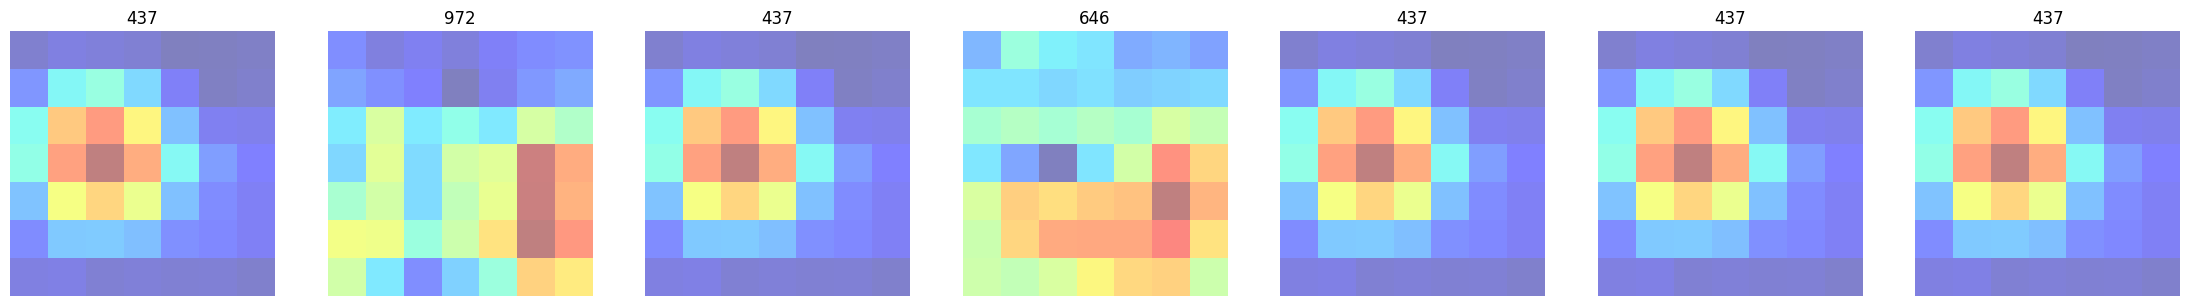

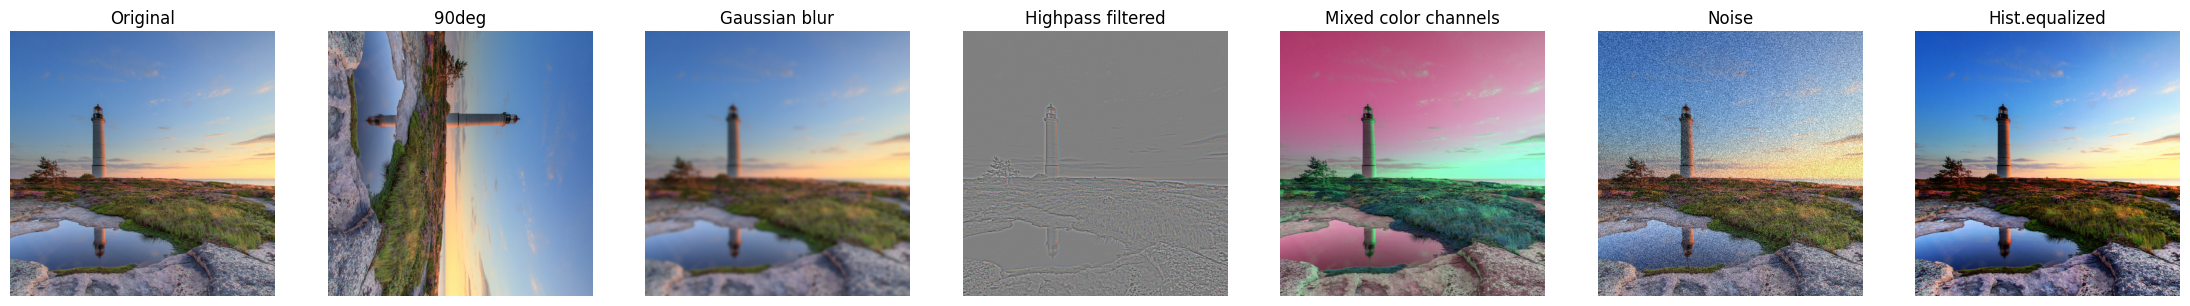

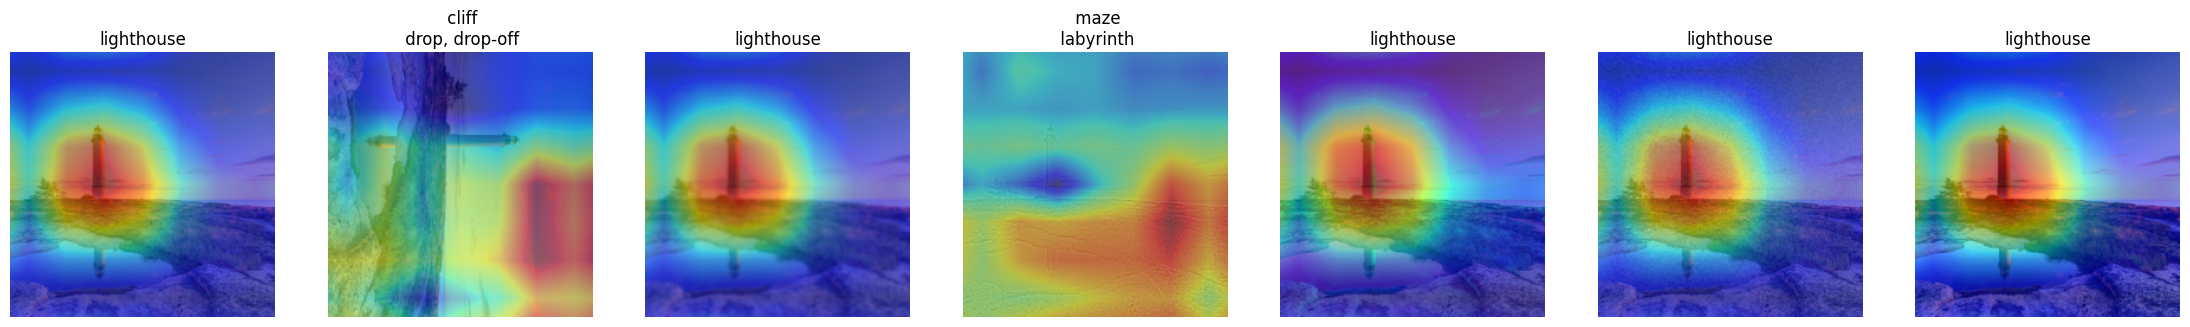

In [144]:
plot_heatmap(overlay_list, class_list)
plot_images(lighthouse_image_list, description)
plot_images_overlay(lighthouse_image_list, lighthouse_tensors, overlay_list, class_list)

 437: 'beacon, lighthouse, beacon light, pharos',
 
 972: 'cliff, drop, drop-off',
 
 646: 'maze, labyrinth',
 

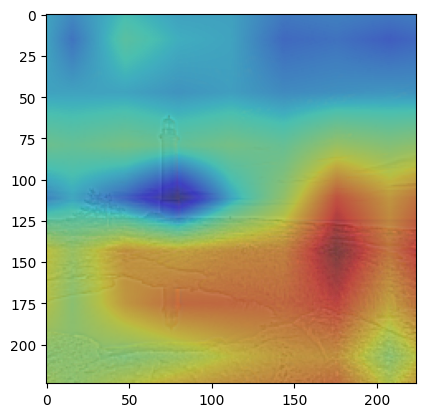

In [145]:
imshow(display_transform(lighthouse_image_list[3]))
imshow(skimage.transform.resize(overlay_list[3][0], lighthouse_tensors[0].shape[1:3]), alpha=0.5, cmap='jet');

## Plot heatmap of second predected class

In [146]:
overlay_list_sec = []
class_list_sec = []
for i in range(len(lighthouse_tensors)):
    class_idx = topk(pred_probabilities_list[i],2)[1].int()
    print(topk(pred_probabilities_list[i],2))
    class_idx = class_idx[1]
    overlay_list_sec.append(getCAM(activated_features.features, weight_softmax, class_idx))
    class_list_sec.append(class_idx)
    activated_features.remove()


torch.return_types.topk(
values=tensor([9.9725e-01, 3.2850e-04]),
indices=tensor([437, 483]))
torch.return_types.topk(
values=tensor([0.6106, 0.0701]),
indices=tensor([972, 976]))
torch.return_types.topk(
values=tensor([0.7377, 0.0419]),
indices=tensor([437, 975]))
torch.return_types.topk(
values=tensor([0.1081, 0.0844]),
indices=tensor([646,  50]))
torch.return_types.topk(
values=tensor([0.9865, 0.0021]),
indices=tensor([437, 460]))
torch.return_types.topk(
values=tensor([0.9774, 0.0043]),
indices=tensor([437, 483]))
torch.return_types.topk(
values=tensor([9.9873e-01, 2.8490e-04]),
indices=tensor([437, 497]))


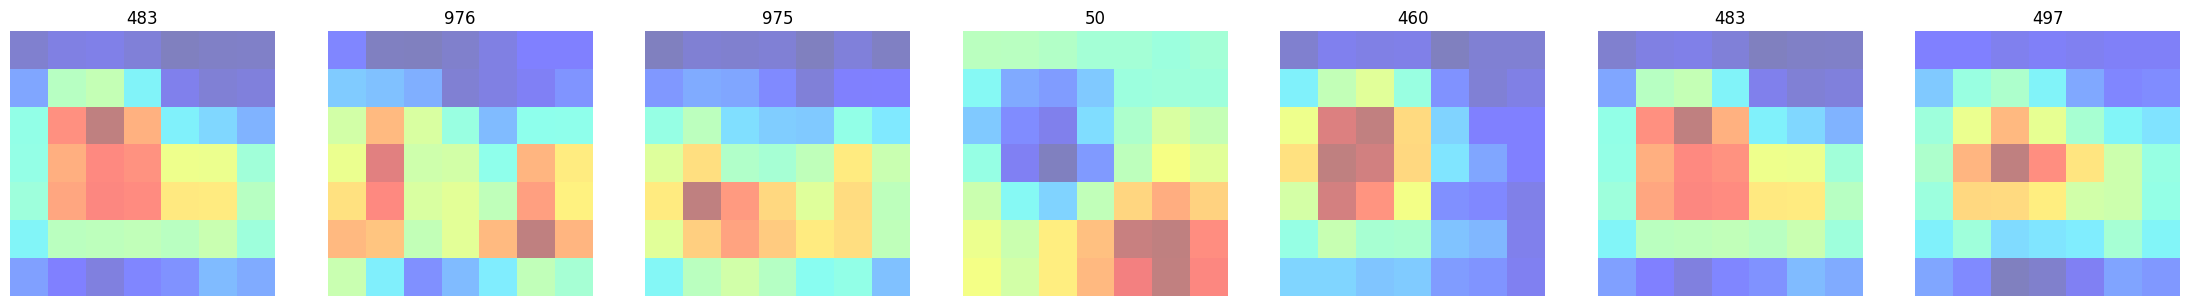

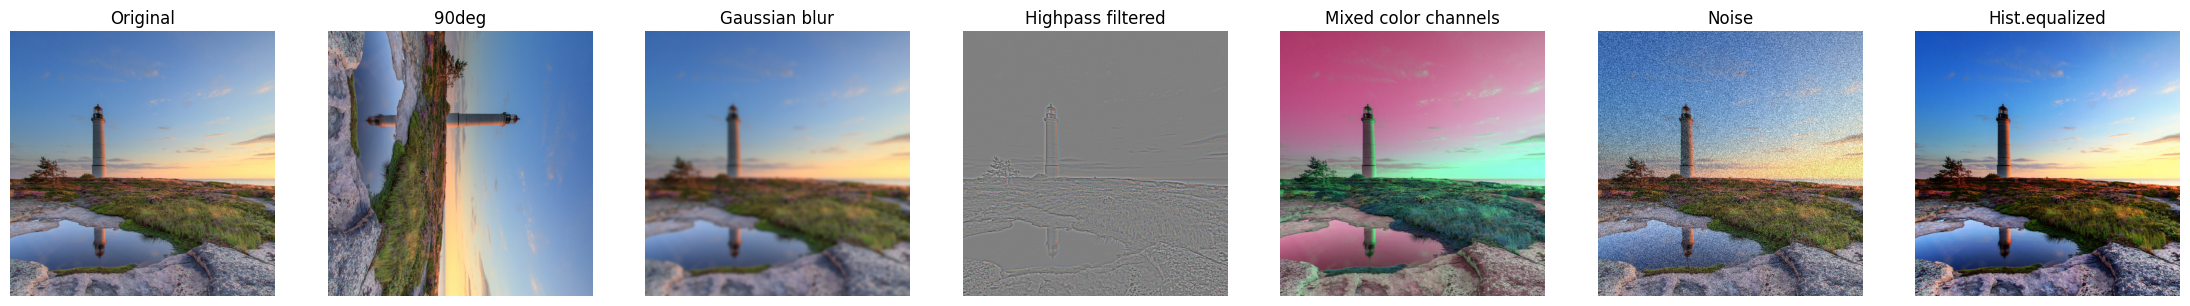

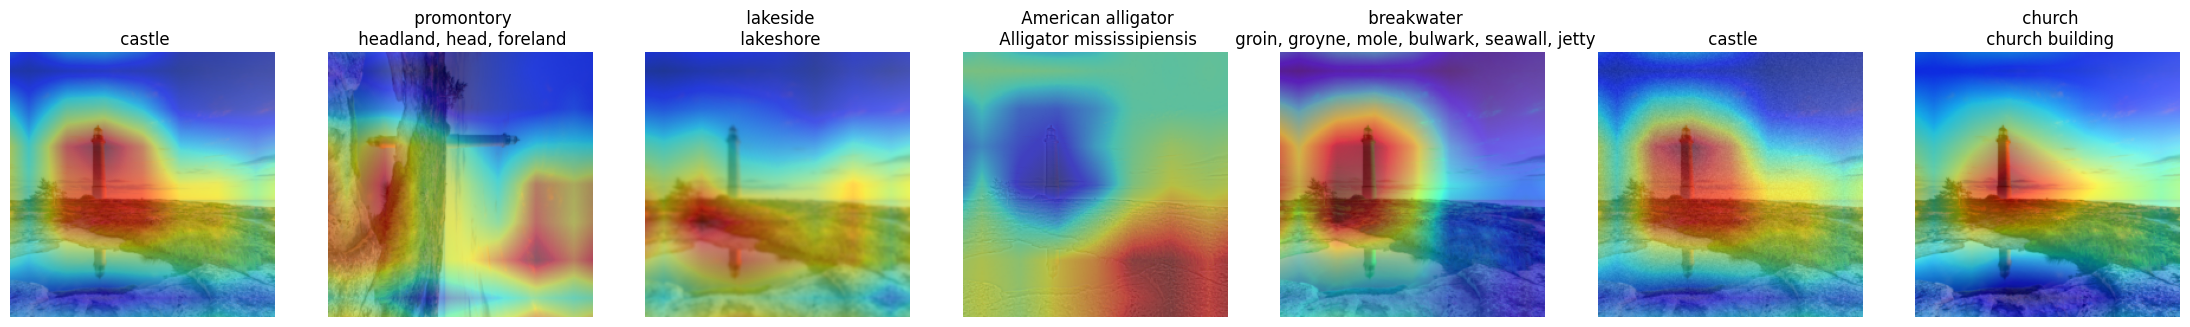

In [147]:
plot_heatmap(overlay_list_sec, class_list_sec)
plot_images(lighthouse_image_list, description)
plot_images_overlay(lighthouse_image_list, lighthouse_tensors ,overlay_list_sec, class_list_sec)

Second choice

483: 'castle' [3.2850e-04]

976: 'promontory, headland, head, foreland' [0.0701]

975: 'lakeside, lakeshore', [0.0419]

50: 'American alligator, Alligator mississipiensis',[0.0419]

460: 'breakwater, groin, groyne, mole, bulwark, seawall, jetty', [0.0021]

483: 'castle', [0.0043]

497: 'church, church building', [2.8490e-04]



## Plot heatmap of other classes
Lets check the heat map for some other classes 

*   527: 'desktop computer'
*   587: 'hammer'
*   497: 'church, church building',


In [148]:
other_class = 497

overlay_list_otherclass = []
class_list_otherclass = []
for i in range(len(lighthouse_tensors)):
    input_image = prediction_var_list[i]
    prediction = model(input_image) 
    class_idx = topk(prediction, 2)[1].int()
    overlay_list_otherclass.append(getCAM(activated_features.features, weight_softmax, other_class))
    
    class_list_otherclass.append(torch.tensor(other_class, dtype=torch.int32))
    activated_features.remove()



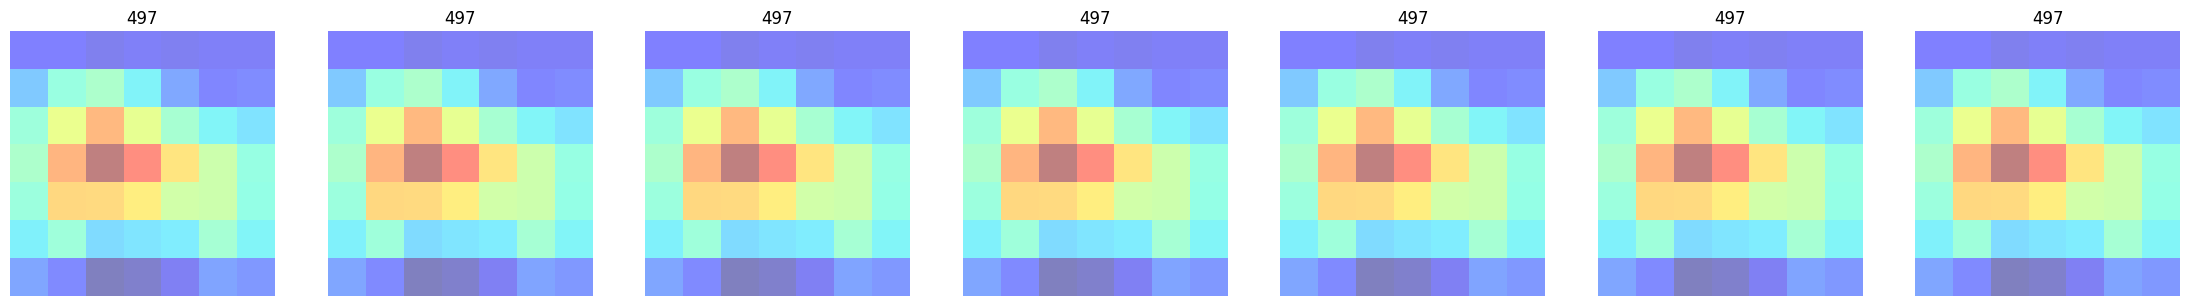

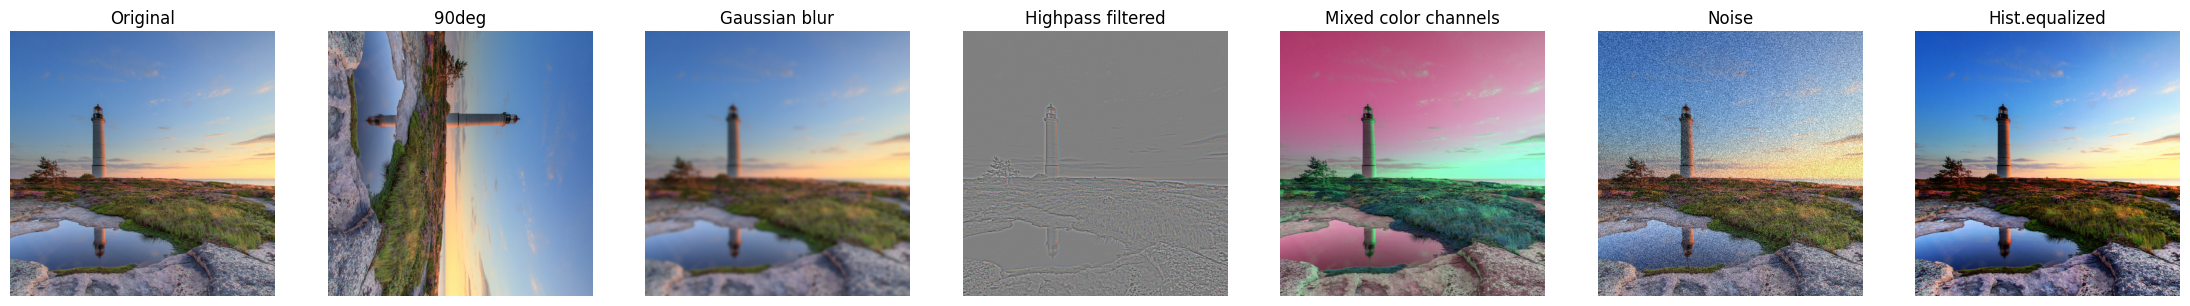

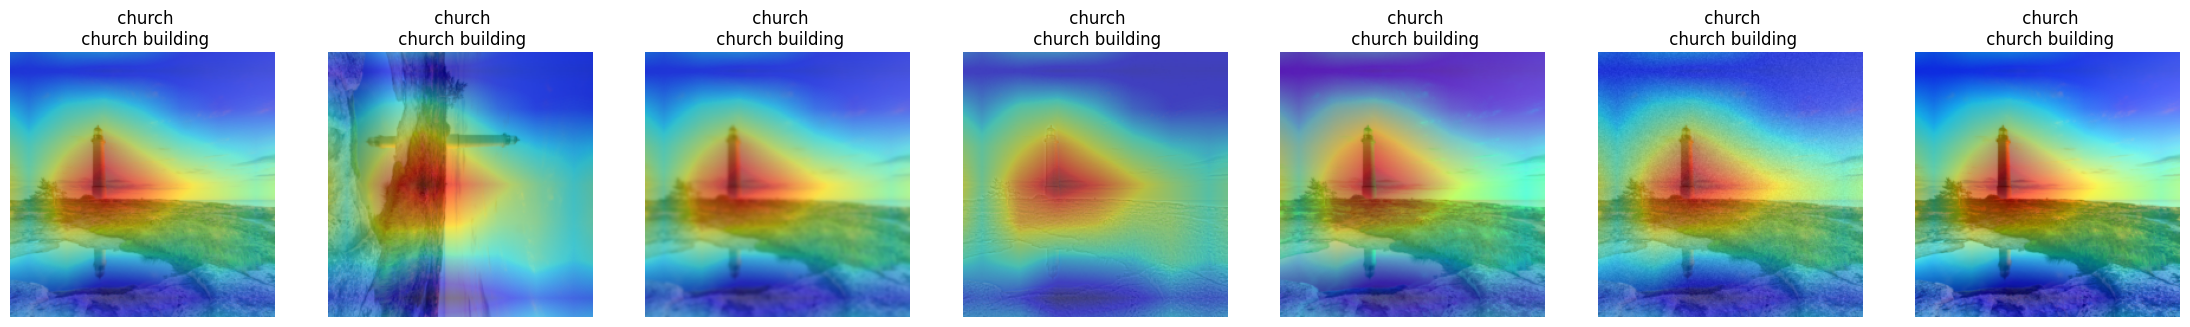

In [149]:
plot_heatmap(overlay_list_otherclass, class_list_otherclass)
plot_images(lighthouse_image_list, description)
plot_images_overlay(lighthouse_image_list,
                    lighthouse_tensors, overlay_list_otherclass, class_list_otherclass)


# Heatmap of other classes

Make prediciton

In [150]:
pred_probabilities_list_image = []

for i in range(len(image_tensors)):
    prediction = model(prediction_var_list_image[i])
    pred_probabilities_list_image.append(F.softmax(prediction).data.squeeze())
    activated_features.remove()

print("Probability and predicted class:")
for i in range(len(image_tensors)):
    probs = topk(pred_probabilities_list_image[i],1)
    # print probabilities and predicted classes
    print(class_name[probs[1].item()], probs[0].item())

weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

overlay_list = []
class_list = []
for i in range(len(image_tensors)):
    class_idx = topk(pred_probabilities_list_image[i],1)[1].int()
    overlay_list.append(getCAM(activated_features.features, weight_softmax, class_idx))
    class_list.append(class_idx)
    activated_features.remove()

Probability and predicted class:
 hatchet 0.5540677905082703
 toilet seat 0.9991310238838196
lighthouse 0.9972507357597351


C:\Users\MSI Laptop\AppData\Local\Temp\ipykernel_6828\1302828530.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities_list_image.append(F.softmax(prediction).data.squeeze())


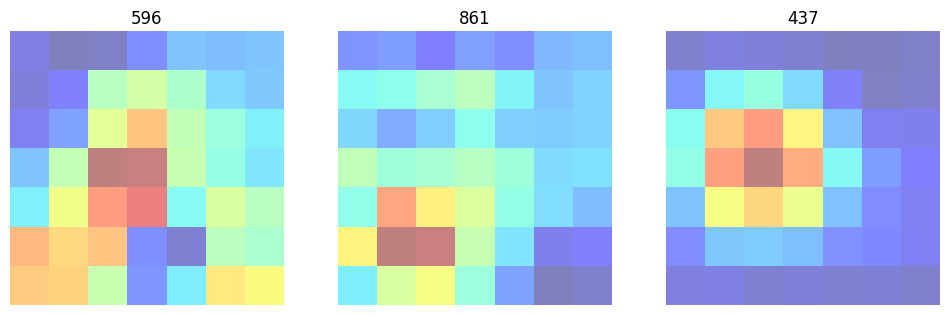

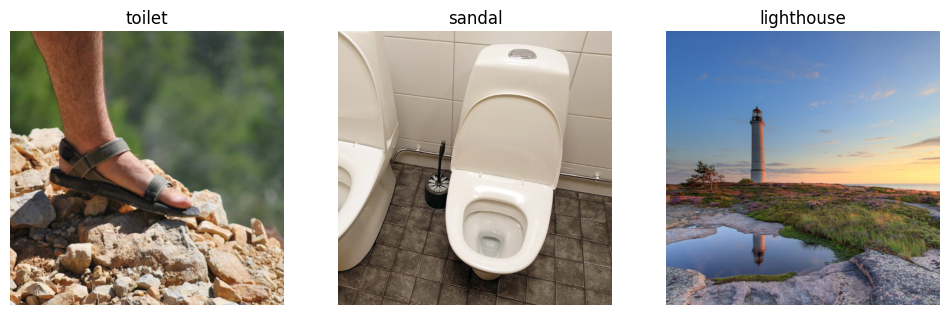

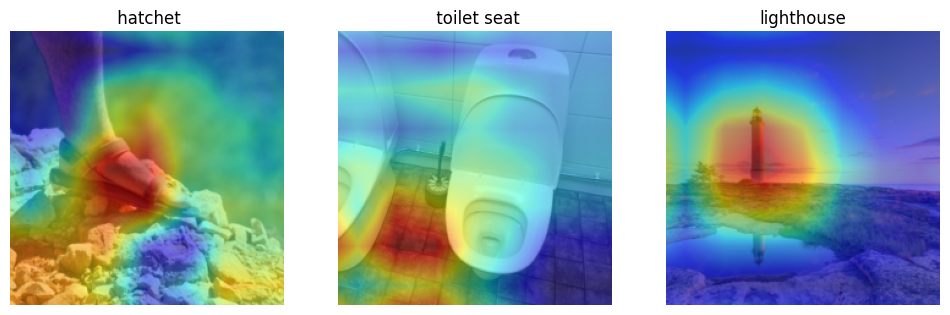

In [151]:
plot_heatmap(overlay_list, class_list)
plot_images(image_list, image_name_list)
plot_images_overlay(image_list, image_tensors, overlay_list, class_list)
